Controlled-experiment Using Pre-Existing Data (CUPED)

[CUPED Article](https://booking.ai/how-booking-com-increases-the-power-of-online-experiments-with-cuped-995d186fff1d)

Variance reduction technique using pre-experiment data.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

np.random.seed(42)

n_samples = 300
group = np.random.choice(['control', 'treatment'], size=n_samples)

# Pre-experiment data e.g transaction amounts (covariate) with stronger correlation to post-experiment outcome
pre_experiment_transactions = np.random.normal(loc=100, scale=30, size=n_samples) ## centered around 100, scale = standard deviation

# True treatment effect (e.g. new algorithm increases transaction amounts)
true_treatment_effect = 20

# Post-experiment data e.g. transaction amounts (outcome)
post_experiment_transactions = pre_experiment_transactions + (group == 'treatment') * true_treatment_effect + np.random.normal(loc=0, scale=60, size=n_samples) ## noise but effect is true in this case.

df = pd.DataFrame({
    'group': group,
    'pre_experiment_transactions': pre_experiment_transactions,
    'post_experiment_transactions': post_experiment_transactions
})

df.head()

,group,pre_experiment_transactions,post_experiment_transactions
0,control,94.229171,114.168012
1,treatment,109.046420,84.137228
2,control,98.958647,192.027765
3,control,64.939659,71.880137
4,control,134.284684,205.042515


In [18]:
# Step 1: Compute the covariance and variance of pre-experiment and post-experiment data
cov = np.cov(df['pre_experiment_transactions'], df['post_experiment_transactions'])[0, 1]
var_pre = np.var(df['pre_experiment_transactions'])

# Step 2: Compute theta, the CUPED adjustment factor
theta = cov / var_pre

# Step 3: Adjust the post-experiment data using pre-experiment data
df['cuped_outcome'] = df['post_experiment_transactions'] - theta * (df['pre_experiment_transactions'] - df['pre_experiment_transactions'].mean())

df.head()

,group,pre_experiment_transactions,post_experiment_transactions,cuped_outcome
0,control,94.229171,114.168012,122.054914
1,treatment,109.046420,84.137228,76.192373
2,control,98.958647,192.027765,194.861374
3,control,64.939659,71.880137,111.061947
4,control,134.284684,205.042515,170.131381


In [21]:
## overview

# Calculate the means of the control and treatment groups before and after CUPED
mean_post_control = df[df['group'] == 'control']['post_experiment_transactions'].mean()
mean_post_treatment = df[df['group'] == 'treatment']['post_experiment_transactions'].mean()
mean_cuped_control = df[df['group'] == 'control']['cuped_outcome'].mean()
mean_cuped_treatment = df[df['group'] == 'treatment']['cuped_outcome'].mean()

# Calculate the difference in means
difference_before_cuped = mean_post_treatment - mean_post_control
difference_after_cuped = mean_cuped_treatment - mean_cuped_control

# Calculate the p-values from a t-test
t_stat_before, p_value_before = stats.ttest_ind(
    df[df['group'] == 'control']['post_experiment_transactions'],
    df[df['group'] == 'treatment']['post_experiment_transactions'],
    equal_var=False
)

t_stat_after, p_value_after = stats.ttest_ind(
    df[df['group'] == 'control']['cuped_outcome'],
    df[df['group'] == 'treatment']['cuped_outcome'],
    equal_var=False
)

# Confidence intervals for difference in means
ci_before = stats.norm.interval(0.95, loc=difference_before_cuped, scale=np.std(df['post_experiment_transactions']) / np.sqrt(n_samples))
ci_after = stats.norm.interval(0.95, loc=difference_after_cuped, scale=np.std(df['cuped_outcome']) / np.sqrt(n_samples))

# Print confidence intervals and p-values
print(f"95% Confidence Interval for difference in means (Before CUPED): {ci_before}")
print(f"95% Confidence Interval for difference in means (After CUPED): {ci_after}")
print(f"P-value before CUPED: {p_value_before:.4f}")
print(f"P-value after CUPED: {p_value_after:.4f}")
print('')
# Variance comparison
variance_before = np.var(df['post_experiment_transactions'])
variance_after = np.var(df['cuped_outcome'])
variance_reduction = variance_before - variance_after

print(f"Variance before CUPED: {variance_before:.2f}")
print(f"Variance after CUPED: {variance_after:.2f}")
print(f"Variance reduction: {variance_reduction:.2f}")

95% Confidence Interval for difference in means (Before CUPED): (7.090333513929673, 22.820253386747503)
95% Confidence Interval for difference in means (After CUPED): (9.255579779272107, 23.35755391754778)
P-value before CUPED: 0.0627
P-value after CUPED: 0.0234

Variance before CUPED: 4830.79
Variance after CUPED: 3882.62
Variance reduction: 948.17


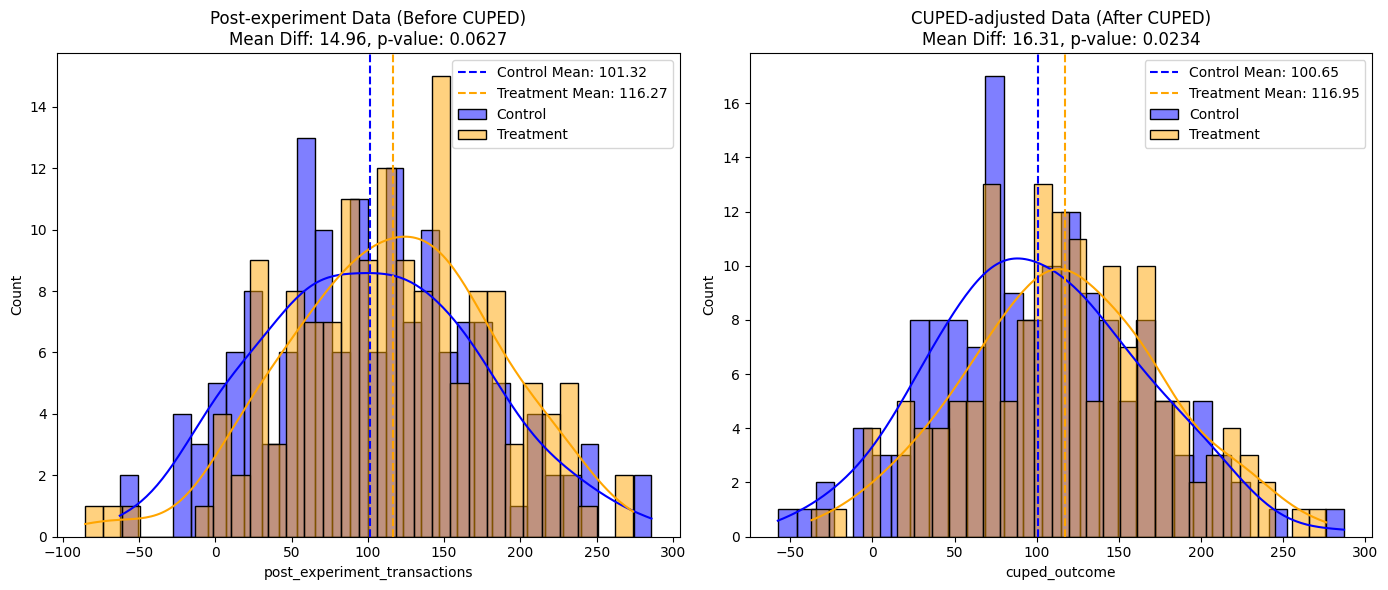

In [22]:
# Plotting: Before and After CUPED
plt.figure(figsize=(14, 6))

# Plot 1: Post-experiment data (before CUPED)
plt.subplot(1, 2, 1)
sns.histplot(df[df['group'] == 'control']['post_experiment_transactions'], color='blue', label='Control', kde=True, bins=30)
sns.histplot(df[df['group'] == 'treatment']['post_experiment_transactions'], color='orange', label='Treatment', kde=True, bins=30)
plt.axvline(mean_post_control, color='blue', linestyle='--', label=f'Control Mean: {mean_post_control:.2f}')
plt.axvline(mean_post_treatment, color='orange', linestyle='--', label=f'Treatment Mean: {mean_post_treatment:.2f}')
plt.title(f'Post-experiment Data (Before CUPED)\nMean Diff: {difference_before_cuped:.2f}, p-value: {p_value_before:.4f}')
plt.legend()

# Plot 2: CUPED-adjusted data
plt.subplot(1, 2, 2)
sns.histplot(df[df['group'] == 'control']['cuped_outcome'], color='blue', label='Control', kde=True, bins=30)
sns.histplot(df[df['group'] == 'treatment']['cuped_outcome'], color='orange', label='Treatment', kde=True, bins=30)
plt.axvline(mean_cuped_control, color='blue', linestyle='--', label=f'Control Mean: {mean_cuped_control:.2f}')
plt.axvline(mean_cuped_treatment, color='orange', linestyle='--', label=f'Treatment Mean: {mean_cuped_treatment:.2f}')
plt.title(f'CUPED-adjusted Data (After CUPED)\nMean Diff: {difference_after_cuped:.2f}, p-value: {p_value_after:.4f}')
plt.legend()

plt.tight_layout()
plt.show()